In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from WindPy import w
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [2]:
def stock_data(stockList, factor, startDate, endDate):
    data = w.wsd(stockList, factor, startDate, endDate, "")
    df = pd.DataFrame(data.Data, columns = data.Times, index = stockList).T
    return df

## 数据初始设置

In [3]:
stockList = ["000300.SH","000016.SH","000905.SH","399006.SZ","399005.SZ","881001.WI","000001.SH"] # 11年往后 有全部数据
# stockList = ["000300.SH","000016.SH","000905.SH","399005.SZ","881001.WI","000001.SH"] # 07年往后 有全部数据
# stockList = ["000300.SH","000016.SH","881001.WI","000001.SH"] # 06年往后 有全部数据
startDate = "20110101"
endDate = "20210101"
N = 1 # N-month return of index

In [4]:
#pd.set_option('display.max_rows', None)

## 指数  $ log \frac{P_{t+T}}{P_t} $  计算N月收益涨跌 (一年约250个交易日 250/N）

In [5]:
def calculateReturn(N,price):
    days = round(250/12 * N)
    returns = np.log(price.shift(-days)/price).fillna(value = 0)
    returns = np.around(returns, decimals = 4, out = None)
    return returns[:-days]

In [6]:
price = stock_data(stockList, "CLOSE", startDate, endDate)
returns = calculateReturn(N,price)

In [7]:
returns

,000300.SH,000016.SH,000905.SH,399006.SZ,399005.SZ,881001.WI,000001.SH
2011-01-04,-0.0478,-0.0364,-0.0836,-0.1194,-0.1199,-0.0424,-0.0279
2011-01-05,-0.0228,-0.0117,-0.0604,-0.0824,-0.0867,-0.0188,-0.0072
2011-01-06,-0.0123,-0.0039,-0.0438,-0.0573,-0.0617,-0.0085,0.0011
2011-01-07,0.0164,0.0204,-0.0208,-0.0361,-0.0394,0.0138,0.0210
2011-01-10,0.0346,0.0333,0.0081,-0.0055,-0.0132,0.0328,0.0378
...,...,...,...,...,...,...,...
2020-11-26,0.0246,0.0192,-0.0088,0.0850,0.0438,0.0101,0.0079
2020-11-27,0.0167,0.0072,-0.0170,0.0820,0.0292,0.0027,-0.0032
2020-11-30,0.0165,0.0137,-0.0193,0.0665,0.0239,0.0005,-0.0038
2020-12-01,0.0092,0.0056,-0.0248,0.0722,0.0190,-0.0049,-0.0109


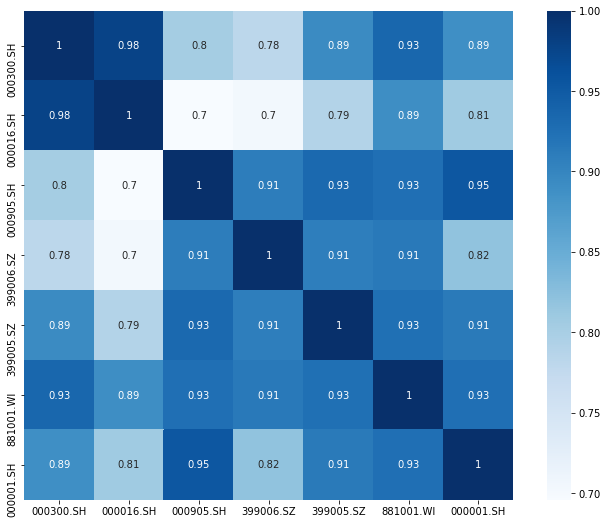

In [8]:
import seaborn as sns
def corr_heat(df):
    dfData = abs(df.corr())
    plt.subplots(figsize=(12, 9)) # 设置画面大小
    sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
    # plt.savefig ('./BluesStateRelation.png')
    plt.show()

corr_heat(price)

### 沪深300/上证50/万得全A/上证指数 可以视为一类；中证500/中小板指/创业板指 可以视为一类
### 因此, 下面以沪深300和创业板指  2个指数为代表进行讨论

In [9]:
stockList = ["000300.SH","399006.SZ"] 
price = stock_data(stockList, "CLOSE", startDate, endDate)

## 沪深300（左轴）与创业板指（右轴） 收盘价

<ipython-input-10-d85340a89b30>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(111)


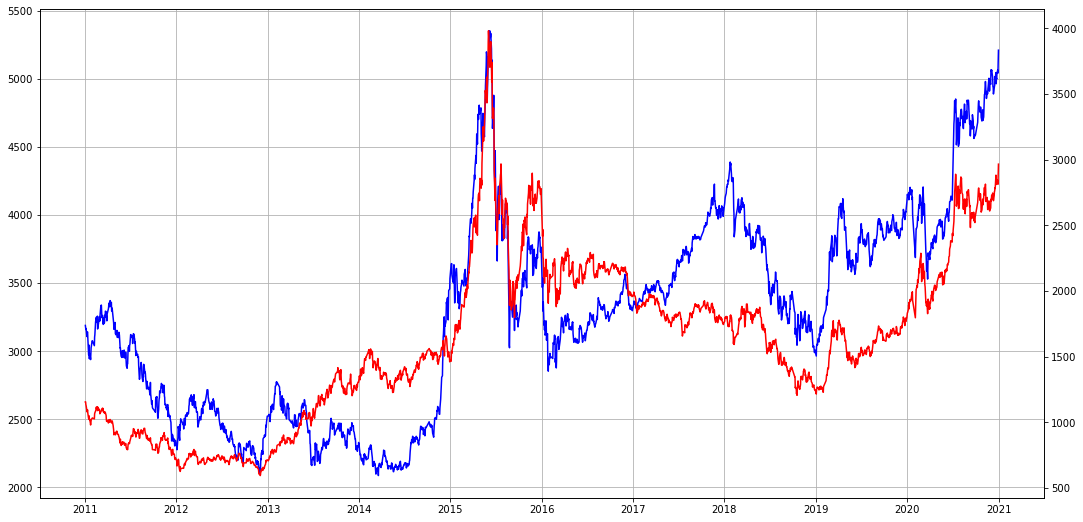

In [10]:
fig = plt.figure(figsize=(18,9))
plt.grid()
ax1 = fig.add_subplot(111)
ax1.plot(price["000300.SH"],color = 'blue')
ax2 = ax1.twinx() 
ax2.plot(price["399006.SZ"],color = 'red')

In [11]:
def position_stock(bins, ratio, position_allocated):
    bins_temp = bins.copy()
    bins_temp.append(ratio)
    bins_temp.sort()
    index = bins_temp.index(ratio)
    return np.around(position_allocated[index],decimals =2)

In [12]:
def updateMoney(t,t_lasttime,position,money,price):
    stock1 = price[price.columns[0]]
    stock2 = price[price.columns[1]]
    stock1Income = (stock1[t]-stock1[t_lasttime])/stock1[t_lasttime]  * position     * money
    stock2Income = (stock2[t]-stock2[t_lasttime])/stock2[t_lasttime]  * (1-position) * money
    money += (stock1Income + stock2Income)
    return money

In [13]:
EP = 1/stock_data(stockList, "pe_ttm", startDate, endDate)
ratio_EP = EP['000300.SH']/EP['399006.SZ']

## 沪深300（左轴）与创业板指（右轴） EP

<ipython-input-14-e73a8a5837da>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(111)


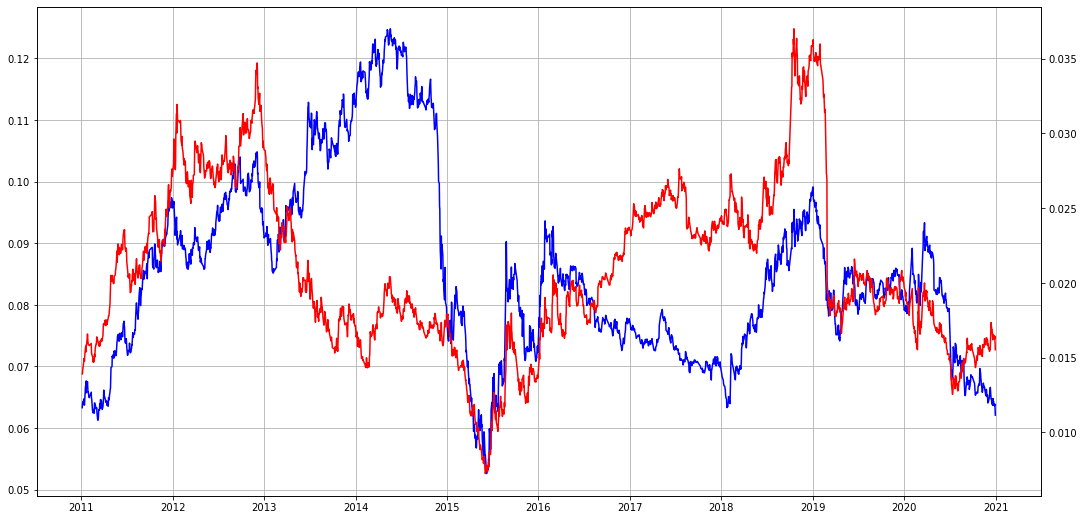

In [14]:
fig = plt.figure(figsize=(18,9))
plt.grid()
ax1 = fig.add_subplot(111)
ax1.plot(EP["000300.SH"],color = 'blue')
ax2 = ax1.twinx() 
ax2.plot(EP["399006.SZ"],color = 'red')

## 根据EP比每月调仓

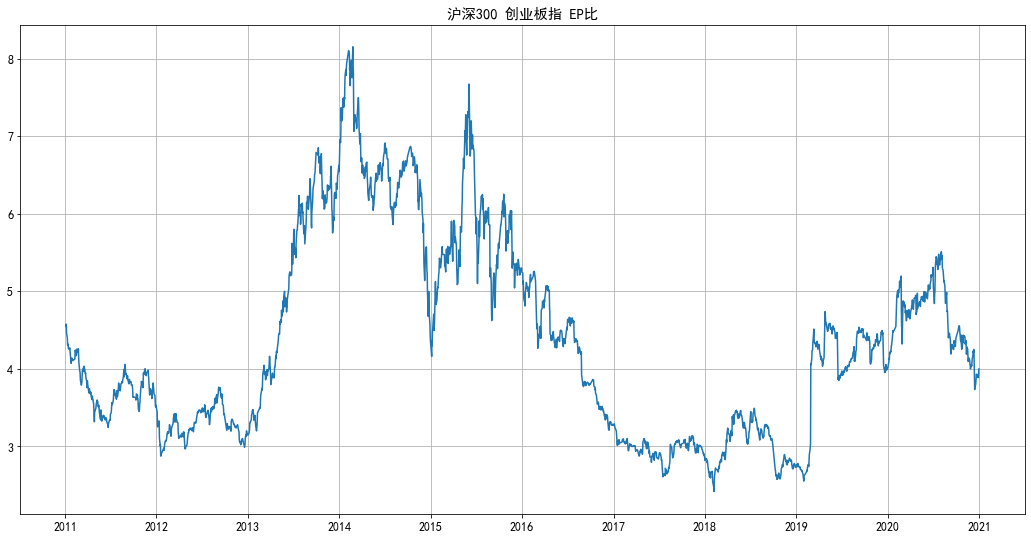

In [15]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rc('font', size=12)
fig = plt.figure(figsize = (18,9))
plt.title("沪深300 创业板指 EP比")
plt.grid()
plt.plot(ratio_EP)

In [16]:
N_sect = 10
gap = (max(ratio_EP) - min(ratio_EP))/N_sect
bins = [i+gap for i in np.arange(min(ratio_EP),max(ratio_EP),gap)][:-1]

position_allocated = [i for i in np.arange(0.1,1.1,0.1)]
position_new = position_lasttime = position_stock(bins,ratio_EP[0],position_allocated)
t = t_lasttime = ratio_EP.index[0]
money = 1

T = []
T.append(t)
weights_allocated = []
weights_allocated.append(position_new)

for i in range(1,len(ratio_EP)):     
    position_new = position_stock(bins,ratio_EP[i],position_allocated)
    if i%21 == 0:
#     if position_new != position_lasttime:
        t = ratio_EP.index[i]
        T.append(t)
        weights_allocated.append(position_new)
        money = updateMoney(t,t_lasttime, position_lasttime,money,price)
        position_lasttime = position_new
        t_lasttime = t
print("沪深300总收益率： " + str(price[price.columns[0]][-1]/price[price.columns[0]][0] - 1) + "   沪深300年化收益率： " + str((price[price.columns[0]][-1]/price[price.columns[0]][0])**(1/10) - 1))
print("创业板指总收益率：" + str(price[price.columns[1]][-1]/price[price.columns[1]][0] - 1) + "   创业板指年化收益率：" + str((price[price.columns[1]][-1]/price[price.columns[1]][0])**(1/10) - 1))
print("策略总收益率：    " + str(money - 1) + "    策略年化收益率：    " + str(money**(1/10) - 1))

沪深300总收益率： 0.6337956260216535   沪深300年化收益率： 0.050315495849283964
创业板指总收益率：1.5679515992471686   创业板指年化收益率：0.09890129047171992
策略总收益率：    1.271085337418012    策略年化收益率：    0.08548379752216673


## EP比（左轴）与对应仓位比（右轴）

<ipython-input-17-b920ede5cec8>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(111)


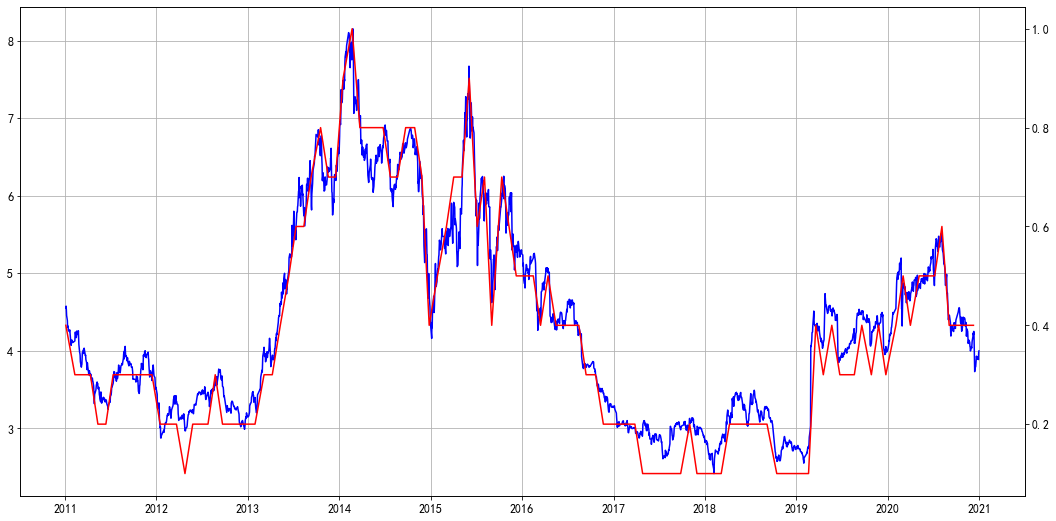

In [17]:
fig = plt.figure(figsize=(18,9))
plt.grid()
ax1 = fig.add_subplot(111)
ax1.plot(ratio_EP,color = 'blue')
ax2 = ax1.twinx() 
ax2.plot(T,weights_allocated,color = 'red')

In [18]:
test = 1/stock_data(stockList, "pb_lf", startDate, endDate)
ratio_test = test['000300.SH']/test['399006.SZ']

## 沪深300（左轴）与创业板指（右轴） BP

<ipython-input-19-2fd0a1649445>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(111)


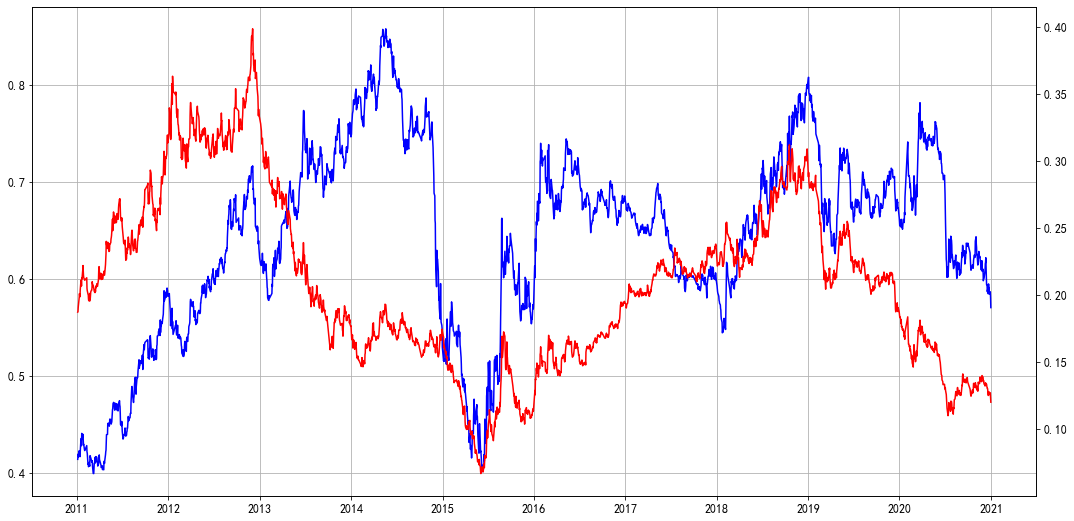

In [19]:
fig = plt.figure(figsize=(18,9))
plt.grid()
ax1 = fig.add_subplot(111)
ax1.plot(test["000300.SH"],color = 'blue')
ax2 = ax1.twinx() 
ax2.plot(test["399006.SZ"],color = 'red')

## 根据BP比每月调仓

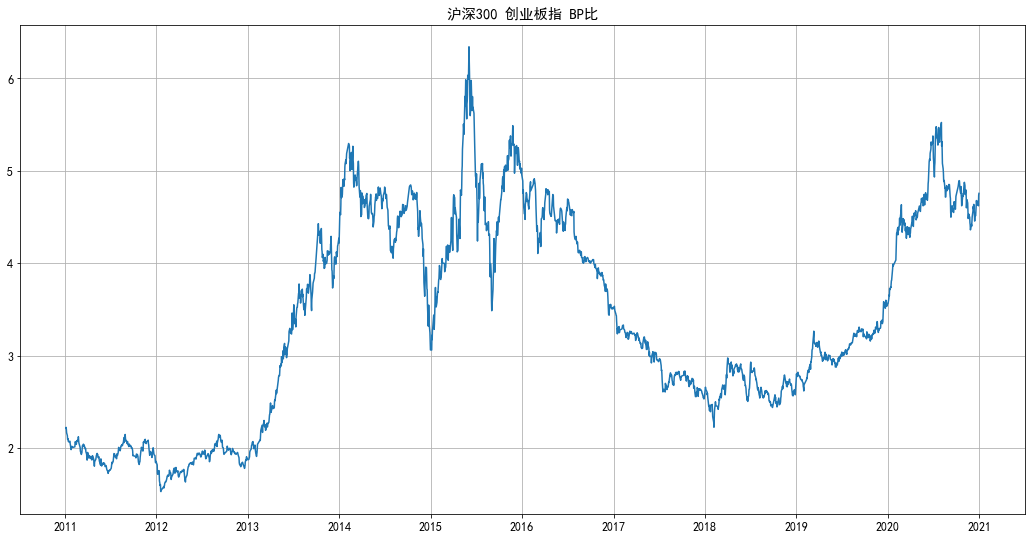

In [20]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rc('font', size=12)
fig = plt.figure(figsize = (18,9))
plt.title("沪深300 创业板指 BP比")
plt.grid()
plt.plot(ratio_test)

In [21]:
N_sect = 10
gap = (max(ratio_test) - min(ratio_test))/N_sect
bins = [i+gap for i in np.arange(min(ratio_test),max(ratio_test),gap)][:-1]

position_allocated = [i for i in np.arange(0.1,1.1,0.1)]
position_new = position_lasttime = position_stock(bins,ratio_test[0],position_allocated)
t = t_lasttime = ratio_test.index[0]
money = 1

T = []
T.append(t)
weights_allocated = []
weights_allocated.append(position_new)

for i in range(1,len(ratio_test)):     
    position_new = position_stock(bins,ratio_test[i],position_allocated)
    if i%21 == 0:
#     if position_new != position_lasttime:
        t = ratio_test.index[i]
        T.append(t)
        weights_allocated.append(position_new)
        money = updateMoney(t,t_lasttime, position_lasttime,money,price)
        position_lasttime = position_new
        t_lasttime = t
print("沪深300总收益率： " + str(price[price.columns[0]][-1]/price[price.columns[0]][0] - 1) + "   沪深300年化收益率： " + str((price[price.columns[0]][-1]/price[price.columns[0]][0])**(1/10) - 1))
print("创业板指总收益率：" + str(price[price.columns[1]][-1]/price[price.columns[1]][0] - 1) + "   创业板指年化收益率：" + str((price[price.columns[1]][-1]/price[price.columns[1]][0])**(1/10) - 1))
print("策略总收益率：    " + str(money - 1) + "    策略年化收益率：    " + str(money**(1/10) - 1))

沪深300总收益率： 0.6337956260216535   沪深300年化收益率： 0.050315495849283964
创业板指总收益率：1.5679515992471686   创业板指年化收益率：0.09890129047171992
策略总收益率：    1.3389502867996774    策略年化收益率：    0.08868464881613347


## BP比（左轴）与对应仓位比（右轴）

<ipython-input-22-b6ebac1242a1>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(111)


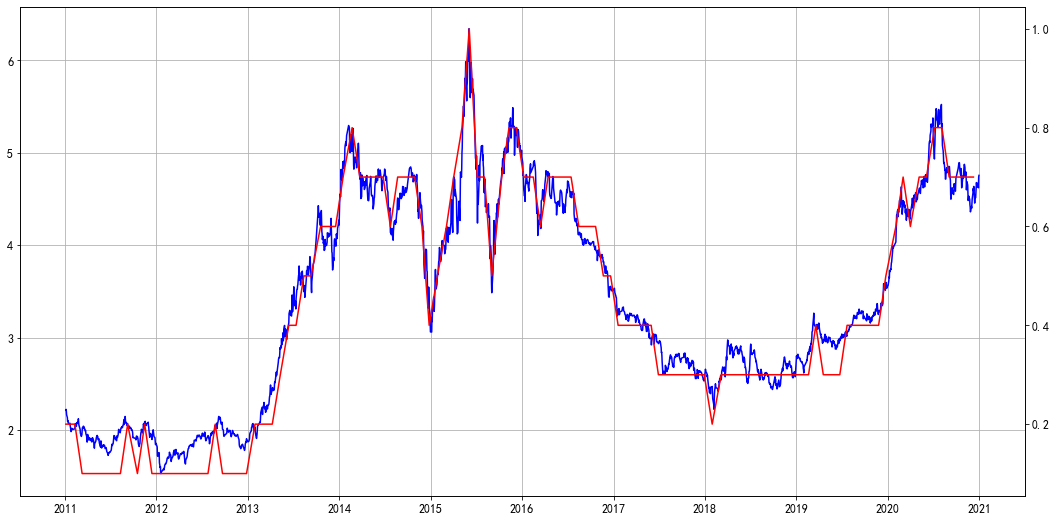

In [22]:
fig = plt.figure(figsize=(18,9))
plt.grid()
ax1 = fig.add_subplot(111)
ax1.plot(ratio_test,color = 'blue')
ax2 = ax1.twinx() 
ax2.plot(T,weights_allocated,color = 'red')

In [23]:
test = 1/stock_data(stockList, "ps_ttm", startDate, endDate)
ratio_test = test['000300.SH']/test['399006.SZ']

## 沪深300（左轴）与创业板指（右轴） SP

<ipython-input-24-2fd0a1649445>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(111)


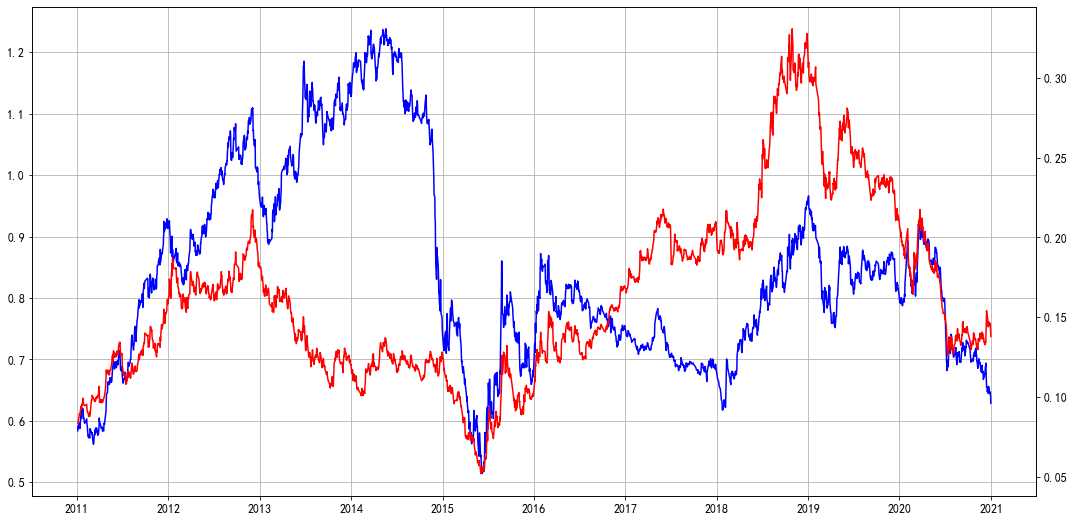

In [24]:
fig = plt.figure(figsize=(18,9))
plt.grid()
ax1 = fig.add_subplot(111)
ax1.plot(test["000300.SH"],color = 'blue')
ax2 = ax1.twinx() 
ax2.plot(test["399006.SZ"],color = 'red')

## 根据SP(市销率倒数）比每月调仓

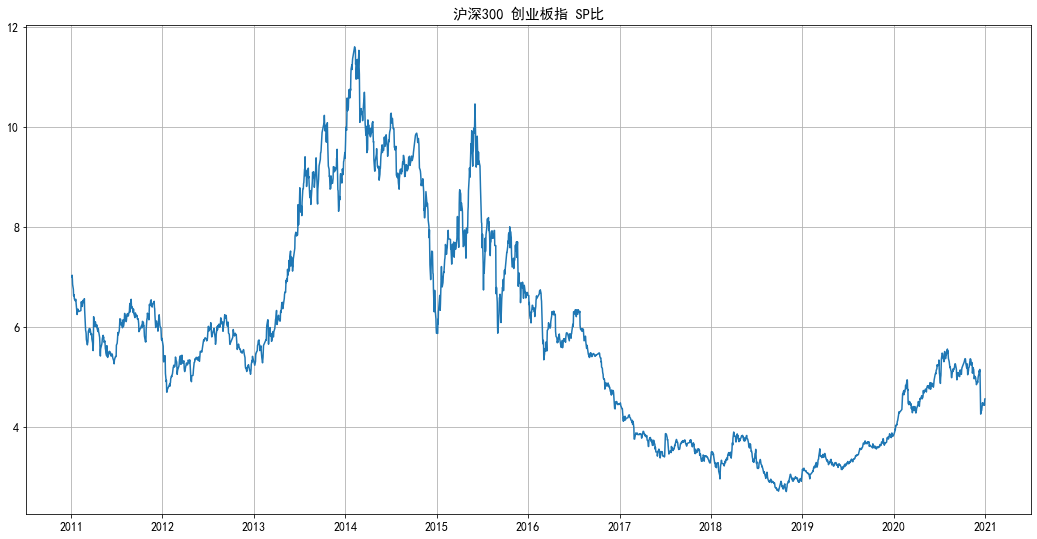

In [25]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rc('font', size=12)
fig = plt.figure(figsize = (18,9))
plt.title("沪深300 创业板指 SP比")
plt.grid()
plt.plot(ratio_test)

In [26]:
N_sect = 10
gap = (max(ratio_test) - min(ratio_test))/N_sect
bins = [i+gap for i in np.arange(min(ratio_test),max(ratio_test),gap)][:-1]

position_allocated = [i for i in np.arange(0.1,1.1,0.1)]
position_new = position_lasttime = position_stock(bins,ratio_test[0],position_allocated)
t = t_lasttime = ratio_test.index[0]
money = 1

T = []
T.append(t)
weights_allocated = []
weights_allocated.append(position_new)

for i in range(1,len(ratio_test)):     
    position_new = position_stock(bins,ratio_test[i],position_allocated)
    if i%21 == 0:
#     if position_new != position_lasttime:
        t = ratio_test.index[i]
        T.append(t)
        weights_allocated.append(position_new)
        money = updateMoney(t,t_lasttime, position_lasttime,money,price)
        position_lasttime = position_new
        t_lasttime = t
print("沪深300总收益率： " + str(price[price.columns[0]][-1]/price[price.columns[0]][0] - 1) + "   沪深300年化收益率： " + str((price[price.columns[0]][-1]/price[price.columns[0]][0])**(1/10) - 1))
print("创业板指总收益率：" + str(price[price.columns[1]][-1]/price[price.columns[1]][0] - 1) + "   创业板指年化收益率：" + str((price[price.columns[1]][-1]/price[price.columns[1]][0])**(1/10) - 1))
print("策略总收益率：    " + str(money - 1) + "    策略年化收益率：    " + str(money**(1/10) - 1))

沪深300总收益率： 0.6337956260216535   沪深300年化收益率： 0.050315495849283964
创业板指总收益率：1.5679515992471686   创业板指年化收益率：0.09890129047171992
策略总收益率：    1.1967715267915087    策略年化收益率：    0.08187849719299045


## SP比（左轴）与对应仓位比（右轴）

<ipython-input-27-b6ebac1242a1>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(111)


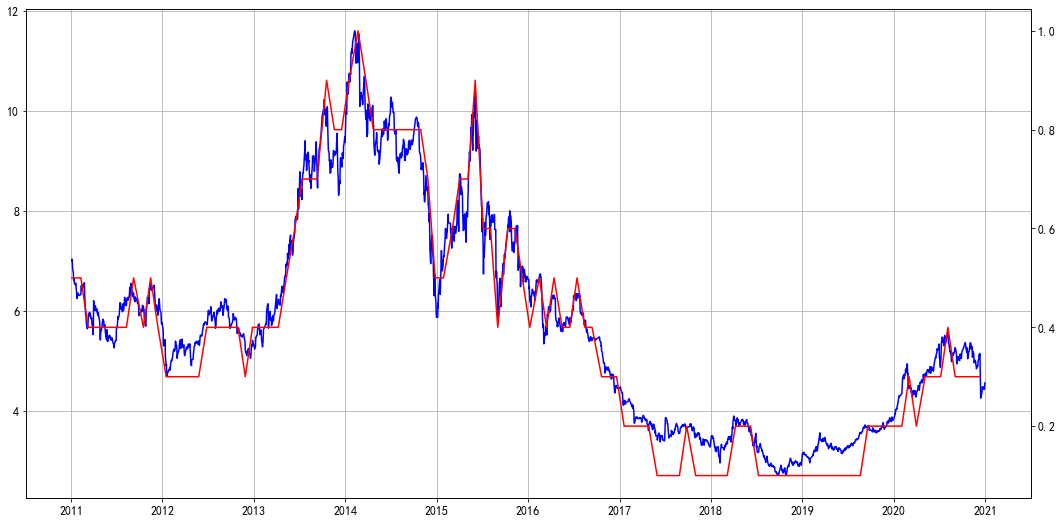

In [27]:
fig = plt.figure(figsize=(18,9))
plt.grid()
ax1 = fig.add_subplot(111)
ax1.plot(ratio_test,color = 'blue')
ax2 = ax1.twinx() 
ax2.plot(T,weights_allocated,color = 'red')

## 策略上限： 观察最理想情况仓位配置下的收益率
### 存在问题:如何根据EP比确定最优仓位

In [28]:
def findBestPosition(t,t_lasttime,price):
    position_allocated = [i for i in np.arange(0,1.1,0.1)]
    stock1 = price[price.columns[0]]
    stock2 = price[price.columns[1]]
    
    stock1Income  = (stock1[t]-stock1[t_lasttime])/stock1[t_lasttime]  * position_allocated[0] 
    stock2Income  = (stock2[t]-stock2[t_lasttime])/stock2[t_lasttime]  * (1-position_allocated[0])
    Income_max    = (stock1Income + stock2Income)
    position_best = position_allocated[0]
    
    for position in position_allocated:
        stock1Income = (stock1[t]-stock1[t_lasttime])/stock1[t_lasttime]  * position    
        stock2Income = (stock2[t]-stock2[t_lasttime])/stock2[t_lasttime]  * (1-position) 
        Income = (stock1Income + stock2Income)
        if Income>Income_max:
            Income_max = Income
            position_best = position 
    return position_best

In [29]:
t = t_lasttime = ratio_EP.index[0]
money = 1

T = []
weights_allocated = []

for i in range(1,len(ratio_EP)):            
    if i%21 == 0:
        t = ratio_EP.index[i]
        T.append(t)
        position = findBestPosition(t,t_lasttime,price)            
        weights_allocated.append(position)
        money = updateMoney(t,t_lasttime, position,money, price)
        t_lasttime = t
print("沪深300总收益率： " + str(price[price.columns[0]][-1]/price[price.columns[0]][0] - 1) + "   沪深300年化收益率： " + str((price[price.columns[0]][-1]/price[price.columns[0]][0])**(1/10) - 1))
print("创业板指总收益率：" + str(price[price.columns[1]][-1]/price[price.columns[1]][0] - 1) + "   创业板指年化收益率：" + str((price[price.columns[1]][-1]/price[price.columns[1]][0])**(1/10) - 1))
print("策略总收益率：    " + str(money - 1) + "    策略年化收益率：    " + str(money**(1/13) - 1))

沪深300总收益率： 0.6337956260216535   沪深300年化收益率： 0.050315495849283964
创业板指总收益率：1.5679515992471686   创业板指年化收益率：0.09890129047171992
策略总收益率：    47.62657520168716    策略年化收益率：    0.3482161156104202


<ipython-input-30-0d23c3bdca3b>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(111)


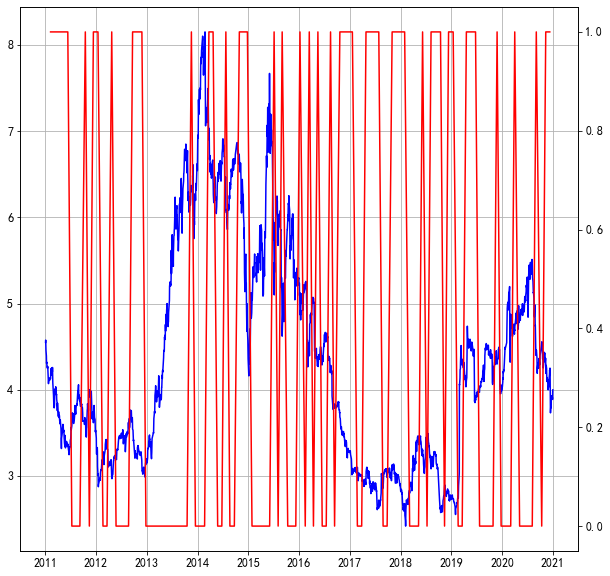

In [30]:
fig = plt.figure(figsize=(10,10))
plt.grid()
ax1 = fig.add_subplot(111)
ax1.plot(ratio_EP,color = 'blue')
ax2 = ax1.twinx() 
ax2.plot(T,weights_allocated,color = 'red')

### 原本思路：自动给这三大类指数分配一个仓位，然后将最优的仓位变化与一些指标（PE,PB等)的变化有没有相关性。
### 结果发现仓位变化高度离散（因为选取仓位的依据是比较两种指数已经发生收益率的大小来配仓（只有0、100%）
### 可能的解决办法：对仓位变动限制，让仓位变化相对连续？？